# Final Project 
- Author: Jennifer Gao
- Date Apr 6, 2025
- This code sets up the foundational components for a molecular generation project using graph neural networks. It first generates a synthetic dataset of simple molecular graphs with random features and target properties (insecticide activity, LogP), saving them to disk. It then defines a Graph Neural Network (GNN) encoder (`MoleculeEncoder`) to map these graphs into a lower-dimensional latent space and a separate predictor (`PropertyPredictor`) to estimate properties from this latent space. Finally, it loads the synthetic data, demonstrates passing a batch through the combined (untrained) model, and includes a function to visualize the initial structure of the latent space using PCA, coloring points by the synthetic insecticide label and annotating with LogP values. Essentially, it prepares the data pipeline and the encoder architecture, but does not yet include training or the generative (diffusion/decoder) part.

- Updated: Apr 13, 2025
- Creating a diffusion model that operates in latent space
- Adding a decoder to transform the latent vectors back to molecular graphs
- Implementing the noise scheduling and sampling procedure

Setup

In [1]:
import numpy as np
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import networkx as nx
import os

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Create directories
data_dir = './molecular_data'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

os.makedirs(data_dir, exist_ok=True)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

Molecule Generator Function

In [2]:
def generate_simple_molecular_graph(num_nodes=10):
    # Generate node features
    node_features = np.random.rand(num_nodes, 8)
    x = torch.tensor(node_features, dtype=torch.float)
    
    # Create edges (first connect all nodes in a chain)
    edges = []
    for i in range(num_nodes-1):
        edges.append([i, i+1])
    
    # Add some random edges
    for _ in range(num_nodes // 3):
        start = np.random.randint(0, num_nodes)
        end = np.random.randint(0, num_nodes)
        if start != end and [start, end] not in edges and [end, start] not in edges:
            edges.append([start, end])
    
    edge_index = torch.tensor(edges, dtype=torch.long).t()
    
    # Generate edge features
    num_edges = edge_index.shape[1]
    edge_features = np.random.rand(num_edges, 3)
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    
    # Generate target properties
    is_insecticide = np.random.randint(0, 2)
    log_p = np.random.normal(4.5, 1.5)
    y = torch.tensor([[is_insecticide, log_p]], dtype=torch.float)
    
    # Create Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    return data

Molecule Visualization Function

In [3]:
def visualize_molecule(data, save_path=None):
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add nodes and edges
    for i in range(data.x.shape[0]):
        G.add_node(i)
    
    edge_list = data.edge_index.t().numpy()
    for edge in edge_list:
        G.add_edge(edge[0], edge[1])
    
    # Draw the graph
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, 
            node_color=data.x[:, 0].numpy(), 
            with_labels=True, 
            node_size=500, 
            cmap=plt.cm.viridis,
            edge_color='gray',
            width=2.0,
            alpha=0.8)
    
    # Get molecule properties
    is_insecticide = data.y[0, 0].item()
    log_p = data.y[0, 1].item()
    
    plt.title(f"Example Molecule (Insecticide: {'Yes' if is_insecticide == 1 else 'No'}, LogP: {log_p:.2f})")
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    


Generate a Sample Molecule

Sample molecule: 10 nodes, 12 edges


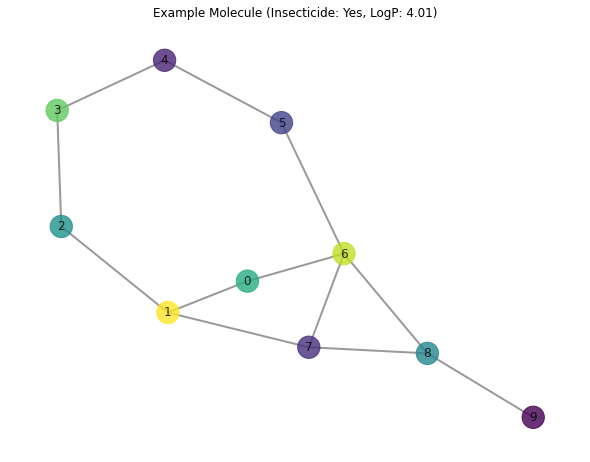

In [4]:
# Generate and visualize a sample molecule
sample = generate_simple_molecular_graph(10)
print(f"Sample molecule: {sample.num_nodes} nodes, {sample.num_edges} edges")
visualize_molecule(sample, "sample_molecule.png")

 Generate Dataset Function

In [5]:
def generate_dataset(num_samples, save_dir, prefix="molecule"):
    print(f"Generating {num_samples} molecules in {save_dir}...")
    
    for i in range(num_samples):
        # Randomly vary the number of nodes
        num_nodes = np.random.randint(5, 30)
        
        # Generate molecule
        data = generate_simple_molecular_graph(num_nodes)
        
        # Save to file
        file_path = os.path.join(save_dir, f'{prefix}_{i}.pt')
        torch.save(data, file_path)
    
    print(f"Generated {num_samples} molecules")

 Generate Training and Validation Datasets

In [6]:
# Generate small datasets for quick testing
generate_dataset(50, train_dir, "train_molecule")
generate_dataset(10, val_dir, "val_molecule")

Generating 50 molecules in ./molecular_data/train...
Generated 50 molecules
Generating 10 molecules in ./molecular_data/val...
Generated 10 molecules


Define Model Components

In [7]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
# Encodes molecular graphs into latent vectors
# Uses Graph Convolutional Networks (GCN) to process nodes and edges
# Uses global pooling to convert node-level features to graph-level features
# Uses a Multi-Layer Perceptron (MLP) to map graph-level features to latent space
class MoleculeEncoder(nn.Module): 
    def __init__(self, node_features, hidden_dim=64, latent_dim=32):
        super(MoleculeEncoder, self).__init__()
        
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        
        x = global_mean_pool(x, batch)
        z = self.mlp(x)
        
        return z
# Predict molecular properties from latent vectors
# Uses an MLP to predict whether a molecule has insecticidal activity and its LogP value
class PropertyPredictor(nn.Module):
    def __init__(self, latent_dim, output_dim=2):
        super(PropertyPredictor, self).__init__()
        
        self.predictor = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, output_dim)
        )
    
    def forward(self, z):
        return self.predictor(z)

Define Complete Model

In [8]:
# combines the encoder and property predictor
# Forward pass:
# Encodes molecular graphs into latent vectors
# Predicts molecular properties from latent vectors
# Returns both the latent vectors and predicted properties

In [9]:
class SimpleModel(nn.Module):
    def __init__(self, node_features, latent_dim=32):
        super(SimpleModel, self).__init__()
        self.encoder = MoleculeEncoder(node_features, latent_dim=latent_dim)
        self.property_predictor = PropertyPredictor(latent_dim)
    
    def forward(self, data):
        z = self.encoder(data)
        props = self.property_predictor(z)
        return z, props

In [10]:
def test_pca(latent_vectors):
    from sklearn.decomposition import PCA
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Apply PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors)
    
    # Print transformation info
    print(f"Original shape: {latent_vectors.shape}")
    print(f"Transformed shape: {latent_2d.shape}")
    print(f"Explained variance: {pca.explained_variance_ratio_}")
    
    # Create a simple scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7)
    plt.title("PCA Test Plot")
    plt.grid(True, alpha=0.3)
    plt.savefig("pca_test.png")
    plt.show()
    
    from IPython.display import Image
    return Image("pca_test.png")

# Test PCA on our sample
test_pca(latent_sample)

NameError: name 'latent_sample' is not defined

Create Dataset and Loader

In [11]:
from torch_geometric.loader import DataLoader

# Custom dataset class
class MoleculeDataset(torch.utils.data.Dataset):
    def __init__(self, directory):
        self.directory = directory
        self.file_list = [f for f in os.listdir(directory) if f.endswith('.pt')]
        print(f"Loaded {len(self.file_list)} molecules from {directory}")
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        file_path = os.path.join(self.directory, self.file_list[idx])
        return torch.load(file_path)

# Create dataset and loader
train_dataset = MoleculeDataset(train_dir)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

Loaded 850 molecules from ./molecular_data/train


Initialize and Test Model

In [12]:
# Initialize model
model = SimpleModel(node_features=8)  # 8 node features in our generated data

# Test model with a batch
batch = next(iter(train_loader))
z, props = model(batch)
print(f"Batch size: {batch.num_graphs}")
print(f"Latent vectors shape: {z.shape}")
print(f"Predicted properties shape: {props.shape}")

Batch size: 8
Latent vectors shape: torch.Size([8, 32])
Predicted properties shape: torch.Size([8, 2])


Latent Space Visualization Function

In [13]:
from sklearn.decomposition import PCA

def visualize_latent_space(model, data_loader, device='cpu'):
    model.eval()
    latent_vectors = []
    insecticide_labels = []
    logp_values = []
    
    # Collect latent representations
    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)
            z, _ = model(batch)
            
            latent_vectors.append(z.cpu().numpy())
            insecticide_labels.append(batch.y[:, 0].cpu().numpy())
            logp_values.append(batch.y[:, 1].cpu().numpy())
    
    # Concatenate all batches
    latent_vectors = np.vstack(latent_vectors)
    insecticide_labels = np.concatenate(insecticide_labels)
    logp_values = np.concatenate(logp_values)
    
    print(f"Collected {len(latent_vectors)} latent vectors")
    
    # Apply PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_vectors)
    
    # Create visualization
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1],
                         c=insecticide_labels,
                         cmap='coolwarm',
                         s=100,
                         alpha=0.7)
    
    # Add LogP labels
    for i, (x, y, logp) in enumerate(zip(latent_2d[:, 0], latent_2d[:, 1], logp_values)):
        plt.text(x, y, f"{logp:.1f}", fontsize=9)
    
    plt.colorbar(scatter, label="Insecticide Activity")
    plt.title("Latent Space Visualization (PCA)")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)")
    plt.grid(alpha=0.3)
    
    plt.savefig("latent_space_viz.png", dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
# Encodes all molecules through the model to get latent vectors

Collected 850 latent vectors


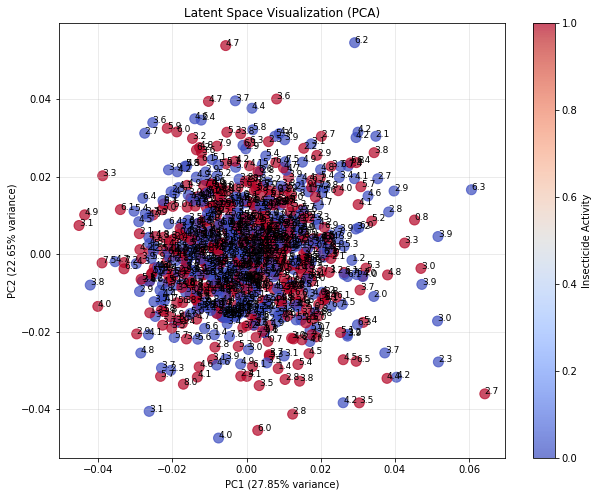

In [15]:
# Visualize latent space
visualize_latent_space(model, train_loader)

In [16]:
# Noise Scheduler: This component manages how noise is gradually added to the latent vectors during training and removed during generation.
# Noise Prediction Network: This network learns to predict the noise that was added at each step.
# Diffusion Process: The forward process (adding noise) and reverse process (removing noise) that are central to diffusion models.
# Sampling Procedure: The algorithm for generating new molecules by starting with random noise and gradually denoising.
# Decoder: A network to convert latent vectors back to molecular graphs.

# April 13 Update

### Noise Scheduler: controls the gradual addition and removal of noise in the latent space

In [22]:
import torch
import torch.nn.functional as F

class NoiseScheduler:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02):
        """
        Initialize the noise scheduler for diffusion process.
        
        Args:
            num_timesteps: Number of diffusion steps
            beta_start: Starting noise level
            beta_end: Ending noise level
        """
        self.num_timesteps = num_timesteps
        
        # Linear beta schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        
        # Pre-compute values used in diffusion process
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # Calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)
        
        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        self.posterior_log_variance_clipped = torch.log(torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]]))
        self.posterior_mean_coef1 = self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)
    
    def add_noise(self, x_start, t, noise=None):
        """
        Forward diffusion process: q(x_t | x_0)
        
        Args:
            x_start: Initial latent vector (clean)
            t: Timestep
            noise: Optional pre-generated noise
        
        Returns:
            Noisy latent vector x_t
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        
        # Get correct scaling factors for each sample in the batch
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].view(-1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].view(-1, 1)
        
        # Apply noise according to schedule
        x_noisy = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
        
        return x_noisy, noise
    
    def get_posterior_parameters(self, x_0, x_t, t):
        """
        Get posterior distribution parameters for q(x_{t-1} | x_t, x_0)
        
        Args:
            x_0: Predicted clean data
            x_t: Current noisy data
            t: Current timestep
        
        Returns:
            Posterior mean and log variance
        """
        posterior_mean_coef1_t = self.posterior_mean_coef1[t].view(-1, 1)
        posterior_mean_coef2_t = self.posterior_mean_coef2[t].view(-1, 1)
        
        # Compute posterior mean
        posterior_mean = posterior_mean_coef1_t * x_0 + posterior_mean_coef2_t * x_t
        
        # Get posterior log variance
        posterior_log_variance_t = self.posterior_log_variance_clipped[t].view(-1, 1)
        
        return posterior_mean, posterior_log_variance_t

# Test the noise scheduler
if __name__ == "__main__":
    # Create a noise scheduler
    scheduler = NoiseScheduler(num_timesteps=1000)
    
    # Create a sample latent vector
    x = torch.randn(2, 32)  # 2 samples, 32-dim latent space
    
    # Test adding noise at different timesteps
    for t in [0, 100, 500, 999]:
        t_tensor = torch.tensor([t, t])
        x_noisy, noise = scheduler.add_noise(x, t_tensor)
        
        print(f"Timestep {t}:")
        print(f"  Original x shape: {x.shape}")
        print(f"  Noisy x shape: {x_noisy.shape}")
        print(f"  Noise shape: {noise.shape}")
        print(f"  Mean noise: {noise.mean().item():.4f}, Std: {noise.std().item():.4f}")
        print(f"  Mean x_noisy: {x_noisy.mean().item():.4f}, Std: {x_noisy.std().item():.4f}")
    
    print("Noise scheduler test completed successfully!")

Timestep 0:
  Original x shape: torch.Size([2, 32])
  Noisy x shape: torch.Size([2, 32])
  Noise shape: torch.Size([2, 32])
  Mean noise: -0.1267, Std: 1.0225
  Mean x_noisy: 0.0590, Std: 1.0602
Timestep 100:
  Original x shape: torch.Size([2, 32])
  Noisy x shape: torch.Size([2, 32])
  Noise shape: torch.Size([2, 32])
  Mean noise: 0.0050, Std: 0.9720
  Mean x_noisy: 0.0586, Std: 1.1243
Timestep 500:
  Original x shape: torch.Size([2, 32])
  Noisy x shape: torch.Size([2, 32])
  Noise shape: torch.Size([2, 32])
  Mean noise: -0.0318, Std: 0.9646
  Mean x_noisy: -0.0137, Std: 0.9327
Timestep 999:
  Original x shape: torch.Size([2, 32])
  Noisy x shape: torch.Size([2, 32])
  Noise shape: torch.Size([2, 32])
  Mean noise: -0.0391, Std: 1.0837
  Mean x_noisy: -0.0387, Std: 1.0829
Noise scheduler test completed successfully!


### Diffusion Model (Noise Prediction Network): predict and remove noise

In [23]:
import torch
import torch.nn as nn

class DiffusionModel(nn.Module):
    def __init__(self, latent_dim=32, time_embed_dim=128, hidden_dims=[256, 512, 256]):
        """
        Initialize the noise prediction network.
        
        Args:
            latent_dim: Dimension of the latent vectors
            time_embed_dim: Dimension of the time step embeddings
            hidden_dims: Dimensions of hidden layers
        """
        super(DiffusionModel, self).__init__()
        
        # Time step embedding
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )
        
        # First layer processes latent vector and time embedding
        self.first_layer = nn.Linear(latent_dim + time_embed_dim, hidden_dims[0])
        
        # Hidden layers
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims) - 1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i + 1]))
        
        # Output layer predicts noise
        self.final_layer = nn.Linear(hidden_dims[-1], latent_dim)
        
        # Activation function
        self.act = nn.SiLU()
    
    def forward(self, x, t):
        """
        Predict noise added to x at timestep t.
        
        Args:
            x: Noisy latent vector
            t: Timestep
        
        Returns:
            Predicted noise
        """
        # Embed timestep
        t_emb = self.time_embed(t.reshape(-1, 1).float())
        
        # Concatenate latent vector and time embedding
        x = torch.cat([x, t_emb], dim=1)
        
        # Forward pass through network
        x = self.act(self.first_layer(x))
        for layer in self.hidden_layers:
            x = self.act(layer(x))
        
        # Output predicted noise
        noise_pred = self.final_layer(x)
        
        return noise_pred

# Test the diffusion model
if __name__ == "__main__":
    # Create a diffusion model
    model = DiffusionModel(latent_dim=32)
    
    # Create a sample batch of latent vectors and timesteps
    batch_size = 4
    x = torch.randn(batch_size, 32)  # 4 samples, 32-dim latent space
    t = torch.randint(0, 1000, (batch_size,))  # Random timesteps
    
    # Forward pass
    noise_pred = model(x, t)
    
    print(f"Input shape: {x.shape}")
    print(f"Timestep shape: {t.shape}")
    print(f"Output noise prediction shape: {noise_pred.shape}")
    print(f"Model parameter count: {sum(p.numel() for p in model.parameters())}")
    
    print("Diffusion model test completed successfully!")

Input shape: torch.Size([4, 32])
Timestep shape: torch.Size([4])
Output noise prediction shape: torch.Size([4, 32])
Model parameter count: 329120
Diffusion model test completed successfully!


### Molecule Decoder: transforms latent vectors back into molecular graph structures

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data

class MoleculeDecoder(nn.Module):
    def __init__(self, latent_dim=32, hidden_dim=64, node_feature_dim=8, edge_feature_dim=3, max_nodes=15):
        """
        Decode latent vectors back to molecular graphs.
        
        Args:
            latent_dim: Dimension of latent vectors
            hidden_dim: Dimension of hidden layers
            node_feature_dim: Dimension of node features
            edge_feature_dim: Dimension of edge features
            max_nodes: Maximum number of nodes in the graph
        """
        super(MoleculeDecoder, self).__init__()
        
        self.max_nodes = max_nodes
        self.node_feature_dim = node_feature_dim
        self.edge_feature_dim = edge_feature_dim
        
        # MLP to decode latent to node features
        self.node_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, max_nodes * node_feature_dim),
        )
        
        # MLP to decode latent to edge existence
        self.edge_existence_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, max_nodes * max_nodes),
        )
        
        # MLP to decode latent to edge features
        self.edge_feature_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.ReLU(),
            nn.Linear(hidden_dim * 2, max_nodes * max_nodes * edge_feature_dim),
        )
        
        # MLP to decode latent to number of nodes
        self.node_count_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, max_nodes),
        )
    
    def forward(self, z):
        """
        Decode latent vector to graph components.
        
        Args:
            z: Latent vector representation
        
        Returns:
            Decoded node features, edge index, edge attributes, and number of nodes
        """
        batch_size = z.shape[0]
        
        # Decode node features
        node_features = self.node_decoder(z).view(batch_size, self.max_nodes, self.node_feature_dim)
        
        # Decode edge existence probabilities
        edge_existence_logits = self.edge_existence_decoder(z).view(batch_size, self.max_nodes, self.max_nodes)
        
        # Make it symmetric and remove self-loops
        edge_existence_logits = (edge_existence_logits + edge_existence_logits.transpose(1, 2)) / 2
        edge_existence_logits = edge_existence_logits * (1 - torch.eye(self.max_nodes, device=z.device))
        
        # Decide on edges (threshold or sample)
        if self.training:
            # During training, use soft probabilities (Gumbel Softmax / straight-through estimator)
            edge_probs = torch.sigmoid(edge_existence_logits)
            
            # Sample edges with straight-through trick for backprop
            edge_sample = (edge_probs > 0.5).float()
            edge_sample_soft = edge_probs + (edge_sample - edge_probs).detach()  # Straight-through estimator
            
            edge_existence = edge_sample_soft
        else:
            # During inference, use hard threshold
            edge_existence = (torch.sigmoid(edge_existence_logits) > 0.5).float()
        
        # Decode edge features
        edge_features = self.edge_feature_decoder(z).view(batch_size, self.max_nodes, self.max_nodes, self.edge_feature_dim)
        
        # Decode number of nodes (as logits)
        node_count_logits = self.node_count_decoder(z)
        
        return node_features, edge_existence, edge_features, node_count_logits
    
    def decode_to_data_object(self, z, threshold=0.5):
        """
        Convert latent vector to PyG Data object.
        
        Args:
            z: Latent vector
            threshold: Threshold for edge existence
        
        Returns:
            PyG Data object representing the molecule
        """
        # Get a single latent vector if batched
        if z.dim() > 1 and z.size(0) > 1:
            z = z[0].unsqueeze(0)  # Just take the first one in the batch
        
        # Decode components
        node_features, edge_existence, edge_features, node_count_logits = self(z)
        
        # Convert from batch form to single
        node_features = node_features[0]
        edge_existence = edge_existence[0]
        edge_features = edge_features[0]
        
        # Determine number of nodes
        if self.training:
            # During training, use soft assignment
            node_count_probs = F.softmax(node_count_logits[0], dim=0)
            num_nodes = torch.argmax(node_count_probs).item() + 1  # +1 because indices start at 0
        else:
            # During inference, take argmax
            num_nodes = torch.argmax(node_count_logits[0]).item() + 1  # +1 because indices start at 0
        
        num_nodes = max(3, min(num_nodes, self.max_nodes))  # Ensure reasonable number of nodes
        
        # Slice to get active part
        node_features = node_features[:num_nodes]
        edge_existence = edge_existence[:num_nodes, :num_nodes]
        edge_features = edge_features[:num_nodes, :num_nodes]
        
        # Get edge indices and attributes from the existence matrix
        edge_index = []
        edge_attr = []
        
        for i in range(num_nodes):
            for j in range(num_nodes):
                if i != j and edge_existence[i, j] > threshold:
                    edge_index.append([i, j])
                    edge_attr.append(edge_features[i, j])
        
        # Convert to tensors
        if edge_index:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t()
            edge_attr = torch.stack(edge_attr)
        else:
            # If no edges, create empty tensors with correct dimensions
            edge_index = torch.zeros((2, 0), dtype=torch.long)
            edge_attr = torch.zeros((0, self.edge_feature_dim), dtype=torch.float)
        
        # Dummy property prediction (can be replaced with your property predictor)
        y = torch.tensor([[0.0, 0.0]], dtype=torch.float)  # Dummy values
        
        # Create Data object
        data = Data(
            x=node_features,
            edge_index=edge_index,
            edge_attr=edge_attr,
            y=y,
            num_nodes=num_nodes
        )
        
        return data

# Test the molecule decoder
if __name__ == "__main__":
    # Import visualization function from your existing code
    # Make sure to import your visualization function here
    # For testing without it, we'll just print the graph structure
    
    # Create a decoder
    decoder = MoleculeDecoder(latent_dim=32, node_feature_dim=8, edge_feature_dim=3)
    
    # Generate a random latent vector
    z = torch.randn(1, 32)
    
    # Decode to graph components
    node_features, edge_existence, edge_features, node_count_logits = decoder(z)
    
    print(f"Node features shape: {node_features.shape}")
    print(f"Edge existence matrix shape: {edge_existence.shape}")
    print(f"Edge features shape: {edge_features.shape}")
    print(f"Node count logits shape: {node_count_logits.shape}")
    
    # Convert to PyG Data object
    data = decoder.decode_to_data_object(z)
    
    print(f"\nDecoded graph:")
    print(f"  Number of nodes: {data.num_nodes}")
    print(f"  Number of edges: {data.num_edges}")
    print(f"  Node feature shape: {data.x.shape}")
    print(f"  Edge index shape: {data.edge_index.shape}")
    print(f"  Edge attribute shape: {data.edge_attr.shape}")
    
    print("Molecule decoder test completed successfully!")

Node features shape: torch.Size([1, 15, 8])
Edge existence matrix shape: torch.Size([1, 15, 15])
Edge features shape: torch.Size([1, 15, 15, 3])
Node count logits shape: torch.Size([1, 15])

Decoded graph:
  Number of nodes: 12
  Number of edges: 56
  Node feature shape: torch.Size([12, 8])
  Edge index shape: torch.Size([2, 56])
  Edge attribute shape: torch.Size([56, 3])
Molecule decoder test completed successfully!


### Complete Molecular Diffusion Model

In [26]:
class DiffusionModel(nn.Module):
    """
    Simple noise prediction network for diffusion model.
    Takes noisy latent vectors and timesteps, predicts the noise component.
    """
    def __init__(self, latent_dim=32, hidden_dim=128):
        super(DiffusionModel, self).__init__()
        
        # Time embedding - transforms timestep into a feature vector
        self.time_embed = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim),
        )
        
        # Main network architecture
        self.net = nn.Sequential(
            # First layer processes latent vector and time embedding
            nn.Linear(latent_dim + hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.SiLU(),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, latent_dim),  # Predict noise in the same dimension as input
        )
    
    def forward(self, x, t):
        """
        Predict noise added to x at timestep t.
        
        Args:
            x: Noisy latent vector [batch_size, latent_dim]
            t: Timestep [batch_size]
        
        Returns:
            Predicted noise [batch_size, latent_dim]
        """
        # Normalize timesteps to [0, 1] range and reshape to [batch_size, 1]
        t_emb = t.float().view(-1, 1) / 1000.0
        
        # Embed timestep
        t_emb = self.time_embed(t_emb)
        
        # Concatenate latent vector and time embedding
        x_input = torch.cat([x, t_emb], dim=1)
        
        # Predict noise
        noise_pred = self.net(x_input)
        
        return noise_pred

# Test code to verify the model
if __name__ == "__main__":
    # Create the noise prediction network
    latent_dim = 32
    model = DiffusionModel(latent_dim=latent_dim)
    print(f"Created diffusion model with {sum(p.numel() for p in model.parameters())} parameters")
    
    # Create dummy inputs
    batch_size = 4
    x = torch.randn(batch_size, latent_dim)  # Noisy latent vectors
    t = torch.randint(0, 1000, (batch_size,))  # Random timesteps
    
    # Forward pass
    predicted_noise = model(x, t)
    
    # Print shapes
    print(f"Input shape: {x.shape}")
    print(f"Timestep shape: {t.shape}")
    print(f"Predicted noise shape: {predicted_noise.shape}")
    
    # Verify that the model is learning something by training it on a simple task
    # We'll train it to predict known noise
    print("\nTesting training loop with simple noise prediction task:")
    
    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Simple training loop
    num_iterations = 100
    for i in range(num_iterations):
        # Generate random latent vectors
        x_clean = torch.randn(batch_size, latent_dim)
        
        # Generate random timesteps
        t = torch.randint(0, 1000, (batch_size,))
        
        # Generate random noise
        true_noise = torch.randn(batch_size, latent_dim)
        
        # Add noise to the clean latent vectors (simplified version)
        t_factor = (t.float() / 1000.0).view(-1, 1)  # Simplified noise factor
        x_noisy = x_clean * (1 - t_factor) + true_noise * t_factor
        
        # Predict noise
        predicted_noise = model(x_noisy, t)
        
        # Calculate loss
        loss = torch.nn.functional.mse_loss(predicted_noise, true_noise)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print progress
        if (i + 1) % 10 == 0:
            print(f"Iteration {i+1}/{num_iterations}, Loss: {loss.item():.6f}")
    
    print("Diffusion model test completed successfully!")

Created diffusion model with 107424 parameters
Input shape: torch.Size([4, 32])
Timestep shape: torch.Size([4])
Predicted noise shape: torch.Size([4, 32])

Testing training loop with simple noise prediction task:
Iteration 10/100, Loss: 1.041545
Iteration 20/100, Loss: 0.952280
Iteration 30/100, Loss: 0.811995
Iteration 40/100, Loss: 0.840538
Iteration 50/100, Loss: 0.794732
Iteration 60/100, Loss: 0.817534
Iteration 70/100, Loss: 1.009179
Iteration 80/100, Loss: 0.901328
Iteration 90/100, Loss: 0.980831
Iteration 100/100, Loss: 1.005941
Diffusion model test completed successfully!


### Training and Evaluation Functions: 
train_diffusion_model: A function that trains the complete molecular diffusion model with a defined training loop, loss tracking, and checkpoint saving.
evaluate_generated_molecules: A function for generating and visualizing molecules using the trained model, with options for unconditioned generation and property-conditioned generation (specifically targeting insecticidal properties).

In [27]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Function to train the diffusion model
def train_diffusion_model(model, train_loader, num_epochs=50, lr=1e-4, device='cpu'):
    """
    Train the molecular diffusion model.
    
    Args:
        model: MolecularDiffusionModel
        train_loader: DataLoader with training graphs
        num_epochs: Number of training epochs
        lr: Learning rate
        device: Device to use for training
    
    Returns:
        Trained model and training statistics
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    # Training statistics
    stats = {'epoch_losses': [], 'diffusion_losses': [], 'property_losses': []}
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_diff_loss = 0.0
        epoch_prop_loss = 0.0
        
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            batch = batch.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch)
            
            # Backward pass
            outputs['loss'].backward()
            
            # Update parameters
            optimizer.step()
            
            # Record statistics
            epoch_loss += outputs['loss'].item()
            epoch_diff_loss += outputs['diffusion_loss'].item()
            epoch_prop_loss += outputs['property_loss'].item()
        
        # Average losses
        avg_loss = epoch_loss / len(train_loader)
        avg_diff_loss = epoch_diff_loss / len(train_loader)
        avg_prop_loss = epoch_prop_loss / len(train_loader)
        
        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, "
              f"Diffusion Loss: {avg_diff_loss:.4f}, Property Loss: {avg_prop_loss:.4f}")
        
        # Record stats
        stats['epoch_losses'].append(avg_loss)
        stats['diffusion_losses'].append(avg_diff_loss)
        stats['property_losses'].append(avg_prop_loss)
        
        # Save model checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), f"diffusion_model_ep{epoch+1}.pt")
    
    return model, stats

# Function to evaluate and visualize generated molecules
def evaluate_generated_molecules(model, num_samples=5, device='cpu', visualize_molecule_func=None):
    """
    Generate and visualize molecules from the diffusion model.
    
    Args:
        model: Trained MolecularDiffusionModel
        num_samples: Number of molecules to generate
        device: Device to use
        visualize_molecule_func: Function to visualize molecules (optional)
    
    Returns:
        Dictionary of generated molecular graphs
    """
    model.eval()
    
    # Generate molecules with different property conditioning
    print(f"Generating {num_samples} molecules...")
    
    # No conditioning - unconstrained generation
    unconditioned_mols = model.sample(num_samples, device=device)
    
    # Condition for insecticide activity (high first property value)
    insecticide_conditioning = torch.tensor([[1.0, 4.5]], device=device).repeat(num_samples, 1)
    insecticide_mols = model.sample(num_samples, device=device, property_conditioning=insecticide_conditioning)
    
    # Condition for non-insecticide (low first property value)
    non_insecticide_conditioning = torch.tensor([[0.0, 4.5]], device=device).repeat(num_samples, 1)
    non_insecticide_mols = model.sample(num_samples, device=device, property_conditioning=non_insecticide_conditioning)
    
    # Visualize molecules if visualization function is provided
    if visualize_molecule_func is not None:
        # Visualize unconditioned molecules
        print("Visualizing unconditioned molecules:")
        for i, mol in enumerate(unconditioned_mols):
            visualize_molecule_func(mol, f"generated_unconditioned_{i}.png")